In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder,StandardScaler
from sklearn.model_selection import GridSearchCV,StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression as LR
from sklearn.linear_model import LinearRegression,Lasso
from sklearn.preprocessing import PolynomialFeatures as PF
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

In [2]:
#读取训练数据和测试数据
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [3]:
#提取特征和标签，并去除无用项
X_train = train_data.iloc[:,2:]
X_test = test_data.iloc[:,1:]
Y_train = train_data.iloc[:,1]

In [4]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       332 non-null    float64
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      417 non-null    float64
 8   Cabin     91 non-null     object 
 9   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 32.8+ KB


In [5]:
#先处理Cabin特征
X_train.loc[:,'Cabin']

0       NaN
1       C85
2       NaN
3      C123
4       NaN
       ... 
886     NaN
887     B42
888     NaN
889    C148
890     NaN
Name: Cabin, Length: 891, dtype: object

In [6]:
#Cabin存在大量缺失值，非缺失部分的首位均为字母
#先对缺失值以众数进行填充
X_train.loc[:,['Age','Cabin','Embarked']] = SimpleImputer(strategy='most_frequent').fit_transform(X_train.loc[:,['Age','Cabin','Embarked']])

#提取Cabin中的首字母并进行映射
X_train.loc[:,'Cabin'] = X_train.loc[:,'Cabin'].apply(lambda x:x[0])

In [7]:
#同样的方法处理测试集
X_test.loc[:,['Age','Cabin','Fare']] = SimpleImputer(strategy='most_frequent').fit_transform(X_test.loc[:,['Age','Cabin','Fare']])
X_test.loc[:,'Cabin'] = X_test.loc[:,'Cabin'].apply(lambda x:x[0])

In [8]:
#在这里采用删除Ticket和Name列，如果后续发现差距较大，可再对两列进行分析
X_train.drop(columns=['Name','Ticket'],inplace=True)
X_test.drop(columns=['Name','Ticket'],inplace=True)

In [9]:
#接下来对各非数值型变量编码
#首先提取object类型的列
cate = X_train.columns[X_train.dtypes == 'object'].tolist()
#剩余列为数值型列
col = X_train.columns.tolist()
for c in cate:
    col.remove(c)

In [10]:
#对object类型变量进行编码
X_train.loc[:,cate] = OrdinalEncoder().fit_transform(X_train.loc[:,cate])
X_test.loc[:,cate] = OrdinalEncoder().fit_transform(X_test.loc[:,cate])

In [11]:
#量纲是否要归一化
ss = False
#对各特征的值进行量纲统一
if ss:
    X_train.loc[:,col] = StandardScaler().fit_transform(X_train.loc[:,col])
    X_test.loc[:,col] = StandardScaler().fit_transform(X_test.loc[:,col])

In [12]:
#分类训练集和测试集进行建模测试
X_train_train,X_train_test,Y_train_train,Y_train_test = train_test_split(X_train,Y_train,test_size=0.3,random_state=420)

## SVC

In [13]:
#建模SVC
clf = SVC(kernel='rbf'
         ,C=1
         ,cache_size=10000
         ).fit(X_train,Y_train)

In [ ]:
#建模SVC
clf = SVC(kernel='linear'
          ,C=1
          ,cache_size=10000
          ,random_state=0
         ).fit(X_train,Y_train)

In [ ]:
#交叉验证
cross_val_score(clf,X_train,Y_train,cv=10,scoring='accuracy')

In [ ]:
#建模测试SVC
Kernel = ['linear','poly','rbf','sigmoid']

for kernel in Kernel:
    clf = SVC(kernel=kernel
             ,C=1
             ,gamma='auto'
             ,degree=1
             ,cache_size=10000
             ,random_state=0
             ).fit(X_train_train,Y_train_train)
    print('当Kernel为%s时的分数为：%f' % (kernel,clf.score(X_train_test, Y_train_test)))

In [ ]:
#Time Warning:2-3min
run = False
#rbf和linear分数一样的情况下，进行网格搜索，确定最佳的gamma值和C值，来看rbf会不会进一步提升
if run:
    gamma_range = np.logspace(-1,1,20)
    C_range = np.linspace(1,5,100)

    param_grid = dict(gamma = gamma_range,C = C_range)
    #相当于交叉验证
    cv = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=420)

    grid = GridSearchCV(SVC(kernel='rbf',cache_size=10000)
                       ,param_grid=param_grid
                       ,cv=cv
                       )
    grid.fit(X_train_train,Y_train_train)
    print(grid.best_params_)
    print(grid.best_score_)

In [ ]:
#调节C值，看linear会不会有提升
C_range = np.linspace(0.1,20,100)
score = []
for i in C_range:
    svc = SVC(kernel='linear',C=i,cache_size=10000).fit(X_train_train,Y_train_train)
    score.append(svc.score(X_train_test,Y_train_test))
print(max(score),C_range[score.index(max(score))])
plt.plot(C_range,score)
plt.show()

In [ ]:
#基于rbf的结果再次建模
clf_rbf = SVC(kernel='linear'
             ,C=1
             ,cache_size=10000
             ,random_state=0
             ).fit(X_train_train,Y_train_train)
clf_rbf.score(X_train_test, Y_train_test)

In [ ]:
#最终的调参结果为linear最佳

#使用linear对训练集进行训练，并计算测试集的y值
clf_finall = SVC(kernel='linear'
             ,C=1
             ,cache_size=10000
             ,random_state=0
             ).fit(X_train,Y_train)
Y_test = clf_finall.predict(X_test)
Y_test = pd.DataFrame(Y_test)

In [ ]:
#输出SVC结果
write = False
if write == True:
    Y_test.to_csv('0304result.csv')

## 逻辑回归

In [ ]:
#建模测试逻辑回归
lr = LR(penalty='l2'
       ,C=1
       ,max_iter=200
       #,solver='saga'
       ).fit(X_train_train,Y_train_train)
lr.score(X_train_test,Y_train_test)

In [ ]:
# Time Warning:5+ Min
run = False

#网格搜索逻辑回归
if run:
    max_iter_range = np.arange(200,1000,20)
    C_range = np.linspace(0.1,100,100)

    param_grid = dict(max_iter = max_iter_range,C = C_range)
    #相当于交叉验证
    cv = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=420)

    grid = GridSearchCV(LR()
                       ,param_grid=param_grid
                       ,cv=cv
                       )
    grid.fit(X_train_train,Y_train_train)
    print(grid.best_params_)
    print(grid.best_score_)

In [ ]:
#调节C值，看LR会不会有提升
C_range = np.linspace(0.01,10,100)
score = []
for i in C_range:
    lr_ = LR(C=i,solver='saga').fit(X_train_train,Y_train_train)
    score.append(lr_.score(X_train_test,Y_train_test))
print(max(score),C_range[score.index(max(score))])
plt.plot(C_range,score)
plt.show()

In [ ]:
#使用逻辑回归进行模型预测
lr_finall = LR(C=1.1
             ).fit(X_train,Y_train)
Y_test = lr_finall.predict(X_test)
Y_test = pd.DataFrame(Y_test)

In [ ]:
#输出逻辑回归结果
write = False
if write == True:
    Y_test.to_csv('0306result.csv')

## 随机森林

In [45]:
#建模随机森林
rfc = RFC(n_estimators=100
         ,criterion='entropy'
         ,max_depth=5
         ).fit(X_train_train,Y_train_train)
rfc.score(X_train_test,Y_train_test)

0.8470149253731343

In [41]:
# Time Warning:5+ Min
run = True

#网格搜索随机森林
if run:
    max_depth_range = np.arange(2,6)
    n_estimators_range = np.arange(100,501,100)

    param_grid = dict(max_depth = max_depth_range,n_estimators = n_estimators_range)
    #相当于交叉验证
    cv = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=420)

    grid = GridSearchCV(RFC(random_state=None
                            ,criterion='entropy'
                           )
                       ,param_grid=param_grid
                       ,cv=cv
                       )
    grid.fit(X_train_train,Y_train_train)
    print(grid.best_params_)
    print(grid.best_score_)

{'max_depth': 5, 'n_estimators': 100}
0.8224598930481284


In [162]:
#使用随机森林进行模型预测
rfc_finall = RFC(n_estimators=500
                 ,criterion='entropy'
                 ,max_depth=5
                 ).fit(X_train,Y_train)
print(rfc_finall.score(X_train,Y_train))
Y_test = rfc_finall.predict(X_test)
Y_test = pd.DataFrame(Y_test)

0.8641975308641975


In [164]:
#取得较高的随机森林分数
while rfc_finall.score(X_train,Y_train) < 0.865:
    rfc_finall = RFC(n_estimators=500
                     ,criterion='entropy'
                     ,max_depth=5
                     ).fit(X_train,Y_train)
    print(rfc_finall.score(X_train,Y_train))

0.8641975308641975
0.8585858585858586
0.8585858585858586
0.8608305274971941
0.856341189674523
0.8585858585858586
0.8529741863075196
0.856341189674523
0.8597081930415263
0.8608305274971941
0.8574635241301908
0.8608305274971941
0.8552188552188552
0.8653198653198653


In [202]:
Y_test = rfc_finall.predict(X_test)
Y_test = pd.DataFrame(Y_test)

In [168]:
#输出随机森林结果
write = False
if write == True:
    Y_test.to_csv('0307result.csv')

In [165]:
rfc_finall.score(X_train,Y_train)

0.8653198653198653

## 线性回归与多元线性回归(有点扯。用回归器跑分类)

In [171]:
#建模线性回归
lir = LinearRegression().fit(X_train_train,Y_train_train)
lir.score(X_train_test,Y_train_test)

0.4559388497907918

In [176]:
#建模Lasso回归
lasso = Lasso(alpha=0.0001).fit(X_train_train,Y_train_train)
lasso.score(X_train_test,Y_train_test)

0.45591591799554976

In [193]:
#进行多元线性回归
pf = PF(degree=2)
X_train_train_ = pf.fit_transform(X_train_train)
X_train_test_ = pf.fit_transform(X_train_test)

In [194]:
#验证多元提升后的效果
lir_pf = LinearRegression().fit(X_train_train_,Y_train_train)
lir_pf.score(X_train_test_,Y_train_test)

0.3661974637235893

In [207]:
### 线性回归效果不好，弃用

## 聚类算法Kmeans

In [197]:
#建模Kmeans
kmeans = KMeans(n_clusters=2).fit(X_train_train,Y_train_train)
kmeans.score(X_train_test,Y_train_test)

-703499.4156571546

In [198]:
kmeans.predict(X_train_test)

array([1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 0, 1])

In [199]:
kmeans = KMeans(n_clusters=2).fit(X_train,Y_train)
Y_test = kmeans.predict(X_test)
Y_test = pd.DataFrame(Y_test)

In [203]:
Y_test.value_counts()

0    286
1    132
dtype: int64

In [204]:
Y_train.value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [208]:
### 聚类算法效果不好，弃用

## 决策树

In [238]:
#建模决策树
dtc = DecisionTreeClassifier(max_depth=5
                            # ,criterion='entropy'
                            ).fit(X_train_train,Y_train_train)
dtc.score(X_train_test,Y_train_test)

0.8208955223880597

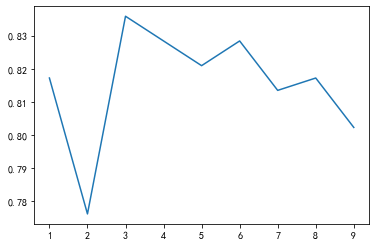

3 0.835820895522388


In [247]:
#绘制max_depth学习曲线
score = []
for i in range(1,10):
    dtc = DecisionTreeClassifier(max_depth=i
                            # ,criterion='entropy'
                            ).fit(X_train_train,Y_train_train)
    score.append(dtc.score(X_train_test,Y_train_test))
plt.plot(range(1,10),score)
plt.show()
print(score.index(max(score))+1,max(score))

In [248]:
#根据学习曲线可知在max_depth为3时的分数最高，以此来建模
dtc_finall = DecisionTreeClassifier(max_depth=3
                            # ,criterion='entropy'
                            ).fit(X_train,Y_train)
Y_test = dtc_finall.predict(X_test)
Y_test = pd.DataFrame(Y_test)

In [251]:
#输出决策树结果
write = False
if write == True:
    Y_test.to_csv('0307result2.csv')

## 高斯朴素贝叶斯

In [13]:
#建模高斯贝叶斯（测试）
gnb = GaussianNB().fit(X_train_train,Y_train_train)
gnb.score(X_train_test,Y_train_test)

0.8097014925373134

In [14]:
#建模
gnb_finall = GaussianNB().fit(X_train,Y_train)
Y_test = gnb_finall.predict(X_test)
Y_test = pd.DataFrame(Y_test)

In [16]:
#输出高斯结果
write = False
if write == True:
    Y_test.to_csv('0308result.csv')

最终的跑分：
随机森林 > 决策树 > 逻辑回归 > SVC(linear) > SVC(rbf)